# Reproducing Hazard Curves from Nath & Thingbaijam (2012)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [44]:
import os
import codecs
import shutil
import warnings
from glob import glob

from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import numpy as np
import pandas as pd
import seaborn as sns

from toolbox import logspace, annotate, read_hazard_csv

Given an occurrence rate $\lambda$ in a given time span $T_1$ and assuming a Poissonian process, the probability of one or more occurrences $P_1$ is

$P_1 = 1 - e ^{-\lambda T_1}$

so given a probability of exceedence, we can compute the rate 

$\lambda = \frac{-1}{T_1} \ln(1 - P_1)$

and work out the probability of exceedence for a different time period.

$P_2 = 1 - e ^{-\lambda T_2}$


In [4]:
def convert_probability(poe_old, T_old, T_new=1):
    return 1 - np.exp(T_new/T_old*np.log(1 - poe_old))

In [5]:
def anonymize(file_name):
    if isinstance(file_name, list):
        return [anonymize(item) for item in file_name]
    return os.path.abspath(file_name).replace(os.path.expanduser('~'), '~')

In [6]:
NATH_PATH = '../Data/nath2012probabilistic'
DIGITIZED_PATH = '../Data/nath2012probabilistic/Figure6'
SITES_CSV = 'NT2012_Table_3_lon_lat.csv'
MAP_CSV = 'NT2012_Figure_7_Indian_subcontinent_lon_lat.csv'
FIGURE_FILE = 'Figure_6_Reproduced.pdf'
TABLE_FILE = 'Table_3_Reproduced.tex'
PLOT_CITIES = np.array([['Bangalore', 'Bhuj', 'Chennai'],
                        ['Guwahati', 'Jabalpur', 'Kolkata'],
                        ['Koyna', 'Mumbai', 'New Delhi']])
T_PLOT = 1  # year

## Job Setup

In [7]:
sites_table = os.path.join(NATH_PATH, 'Table 3.csv')
df_table3 = pd.read_csv(sites_table, skiprows=1, index_col='City')
df_table3

,Latitude (°N),Longitude (°E),BIS,zone,GSHAP,Present,Other,Reference
City,,,,,,,,
Ahmedabad,23.0300,72.610,0.08,III,0.05,0.110,0.1,Jaiswal and Sinha 2007†
Bangalore,12.9800,77.580,0.05,II,0.05,0.110,0.10; 0.15,Jaiswal and Sinha 2007†; Anbazhagan et al. 2009
Bhuj,23.2500,69.660,0.18,V,0.20,0.420,0.25; 0.20-0.70,Jaiswal and Sinha 2007†; Petersen et al. 2004‡
Chennai,13.0000,80.180,0.08,III,0.05,0.120,0.089; 0.10,Menon et al. 2010; Jaiswal and Sinha 2007†
Dehradun,30.3300,78.040,0.12,IV,0.30,0.470,0.45,Mahajan et al. 2010
Guwahati,26.1800,91.730,0.18,V,0.30,0.660,0.5,Sharma and Malik 2006
Hyderabad,17.4500,78.460,0.05,II,0.05,0.090,0.08,Jaiswal and Sinha 2007†
Imphal,24.7800,93.940,0.18,V,0.45,0.680,0.5,Sharma and Malik 2006
Jabalpur,23.2000,79.950,0.08,III,0.10,0.190,0.15,Jaiswal and Sinha 2007†


In [8]:
df_sites = df_table3[['Longitude (°E)', 'Latitude (°N)']]
print('sites_csv = %s' % SITES_CSV)
df_sites.to_csv(SITES_CSV, header=False, index=False, float_format='%g')

sites_csv = NT2012_Table_3_lon_lat.csv


In [9]:
map_imts = ['PGA','SA(0.2)','SA(1.0)']
map_tables = ['India_pga.csv','India_psa_pt2sec.csv','India_psa_1sec.csv']
map_table_list = [os.path.join(NATH_PATH, item) for item in map_tables]
map_table_df_list = [pd.read_csv(file_name) for file_name in map_table_list]

In [10]:
df_map = map_table_df_list[0][['lon', 'lat']]
print('map_csv = %s' % MAP_CSV)
df_map.to_csv(MAP_CSV, header=False, index=False, float_format='%g')

map_csv = NT2012_Figure_7_Indian_subcontinent_lon_lat.csv


In [20]:
poes_nom = np.array([0.1, 0.02])
T_nom = 50  # years
poes_plot = convert_probability(poes_nom, T_nom, T_PLOT)
poe_labels = ['%g%% in %g year' % (100*poe, T_nom) for poe in poes_nom]

print('investigation time: %g year' % T_PLOT)
print('poes = %s' % ' '.join(['%.5g' % poe for poe in poes_plot]))
print(poe_labels)

investigation time: 1 year
poes = 0.002105 0.00040397
['10% in 50 year', '2% in 50 year']


In [21]:
im_types = ['PGA', 'SA(0.2)', 'SA(1.0)']
periods = logspace(0.005, 4, 3)
periods_string = ', '.join([str(T) for T in periods])

print('intensity_measure_types_and_levels = {%s}' 
      % ', '.join(['"%s": [%s]' % (im_type, periods_string) 
                   for im_type in im_types]))

intensity_measure_types_and_levels = {"PGA": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0], "SA(0.2)": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0], "SA(1.0)": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0]}


Note: The calculations below predate the nice report produced by `oq info`.

In [22]:
# areal_plus_gridded_collapsed
n_gmpe_lt_rlzs = 4*4*4*3*4*5*4*4*4
print('n_gmpe_lt_rlzs = %d' % n_gmpe_lt_rlzs)
n_src_lt_rlzs = 3
print('n_src_lt_rlzs = %d' % n_src_lt_rlzs)
n_lt_rlzs = n_gmpe_lt_rlzs*n_src_lt_rlzs
print('n_lt_rlzs = %d' % n_lt_rlzs)
n_sites = len(df_table3)
print('n_sites = %d' % n_sites)
n_imt_iml = len(im_types)*periods.size
print('n_imt_iml = %d' % n_imt_iml)
n_curves = n_lt_rlzs*n_sites*n_imt_iml
print('n_curves = n_lt_rlzs*n_sites*n_imt_iml = %d*%d*%d = %d' %
     (n_lt_rlzs, n_sites, n_imt_iml, n_curves))
n_files = n_lt_rlzs*n_imt_iml
print('n_files = n_lt_rlzs*n_imt_iml = %d*%d = %d' %
     (n_lt_rlzs, n_imt_iml, n_files))

n_gmpe_lt_rlzs = 245760
n_src_lt_rlzs = 3
n_lt_rlzs = 737280
n_sites = 20
n_imt_iml = 27
n_curves = n_lt_rlzs*n_sites*n_imt_iml = 737280*20*27 = 398131200
n_files = n_lt_rlzs*n_imt_iml = 737280*27 = 19906560


In [23]:
# areal_only_collapsed_map
n_gmpe_lt_rlzs = 3*3*2*2*3*2*3*3*2
print('n_gmpe_lt_rlzs = %d' % n_gmpe_lt_rlzs)
n_src_lt_rlzs = 1
print('n_src_lt_rlzs = %d' % n_src_lt_rlzs)
n_lt_rlzs = n_gmpe_lt_rlzs*n_src_lt_rlzs
print('n_lt_rlzs = %d' % n_lt_rlzs)
n_sites = len(df_map)
print('n_sites = %d' % n_sites)
n_imt_iml = len(im_types)
print('n_imt_iml = %d' % n_imt_iml)
n_curves = n_lt_rlzs*n_sites*n_imt_iml
print('n_curves = n_lt_rlzs*n_sites*n_imt_iml = %d*%d*%d = %d' %
     (n_lt_rlzs, n_sites, n_imt_iml, n_curves))
n_files = n_lt_rlzs*n_imt_iml
print('n_files = n_lt_rlzs*n_imt_iml = %d*%d = %d' %
     (n_lt_rlzs, n_imt_iml, n_files))

n_gmpe_lt_rlzs = 3888
n_src_lt_rlzs = 1
n_lt_rlzs = 3888
n_sites = 8102
n_imt_iml = 3
n_curves = n_lt_rlzs*n_sites*n_imt_iml = 3888*8102*3 = 94501728
n_files = n_lt_rlzs*n_imt_iml = 3888*3 = 11664


## Post-Processing

In [24]:
curve_files = sorted([
    os.path.abspath(item) for item in glob(os.path.join('cities_collapsed_v2', '*24348*.csv'))
    if all(key in item for key in ['hazard_curve-', 'mean'])])
curve_files = [item for item in curve_files if any(im_type in item for im_type in im_types)]
anonymize(curve_files)

['~/src/indian-subcontinent-psha/Results/cities_collapsed_v2/hazard_curve-mean-PGA_24348.csv',
 '~/src/indian-subcontinent-psha/Results/cities_collapsed_v2/hazard_curve-mean-SA(0.2)_24348.csv',
 '~/src/indian-subcontinent-psha/Results/cities_collapsed_v2/hazard_curve-mean-SA(1.0)_24348.csv']

/home/nackerle/anaconda3/envs/oq/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


'~/src/indian-subcontinent-psha/Results/Figure_6_Reproduced.pdf'

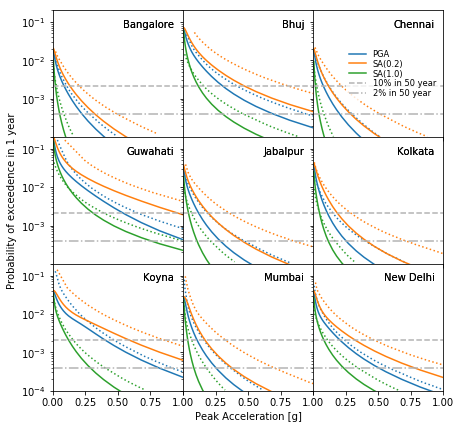

In [39]:
fig, axes = plt.subplots(PLOT_CITIES.shape[0], PLOT_CITIES.shape[1], 
                         figsize=(7, 7), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for curve_file in curve_files:
    poes, config = read_hazard_csv(curve_file)
    label = os.path.split(curve_file)[1]
       
    if config['imt'] == 'PGV':
        warnings.warn('IMT %s units not properly reflected in axis label.' % 
                      config['imt'], UserWarning)
        
    poes = poes.apply(
        lambda x: convert_probability(x, config['investigation_time'], T_PLOT))
        
    for (lon, lat, _), data in poes.iterrows():
        in_table3 = ((df_table3['Longitude (°E)'] == lon) & 
                     (df_table3['Latitude (°N)'] == lat))
        
        if any(in_table3):
            city = in_table3.idxmax()
        else:
            print('Unknown site at %g°N %g°E. Ignoring ...' % (lat, lon))
            continue
            
        if city in PLOT_CITIES:
            ax = axes[PLOT_CITIES == city][0]
            trace = ax.semilogy(data.index, data.values, label=config['imt'])
            
            digitized_csv = '%s_%s.csv' % (city.replace(' ','_'), 
                                           config['imt'].replace('.0', ''))
            digitized_full = os.path.join(DIGITIZED_PATH, digitized_csv)
            if os.path.isfile(digitized_full):
                data = np.genfromtxt(digitized_full, delimiter=',')
                ax.plot(data[:, 0], data[:, 1], 
                        linestyle=':', color=trace[0].get_color())
            else:
                print('%s not found ...' % digitized_csv)

# add reference curves and set limits
for ax, city in zip(axes.ravel(), PLOT_CITIES.ravel()):
    ax.set_xlim((0, 1))
    ax.set_ylim((1e-4, 0.2))
    for prob, label, linestyle in zip(poes_plot, poe_labels, ['--', '-.', ':']):
        ax.axhline(prob, label=label, color='0.7', linestyle=linestyle)
        fig.sca(ax)
        annotate(city, loc='upper right')
    
axes[1,0].set_ylabel(
    'Probability of exceedence in %g year%s' % 
    (T_PLOT, '' if T_PLOT == 1 else 's'))
[ax.yaxis.get_major_ticks()[1].label.set_visible(False) for ax in axes[:-1,0]]
axes[-1,1].set_xlabel('Peak Acceleration [g]')
[ax.xaxis.get_major_ticks()[0].label.set_visible(False) for ax in axes[-1,1:]]
leg = axes[0,-1].legend(loc='center right', frameon=True, fontsize='small', labelspacing=0.1)
leg.get_frame().set_linewidth(0.0)

fig.savefig(FIGURE_FILE, dpi=600, bbox_inches='tight')
anonymize(FIGURE_FILE)

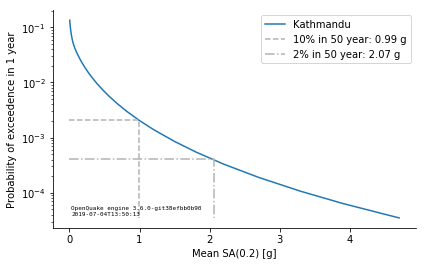

In [80]:
poes, config = read_hazard_csv(curve_files[1])
config.pop('checksum')
config['source'] = config.pop('# generated_by')
T_inv = config.pop('investigation_time')
kind = config.pop('kind')
imt = config.pop('imt')
units = 'cm/s' if imt == 'PGV' else 'g'
city = df_table3.loc['Kathmandu']
poes_series = poes.loc[(city['Longitude (°E)'], city['Latitude (°N)'], 0)]
poes_series = poes_series.apply(lambda x: convert_probability(x, T_inv, T_PLOT))
poes_series.name = city.name

fig, ax = plt.subplots(figsize=(6.5, 4))
poes_series.plot(logy=True, ax=ax)

for prob, label, linestyle in zip(poes_plot, poe_labels, ['--', '-.', ':']):
    intensity = np.interp(prob, poes_series.values[::-1], poes_series.index[::-1])
    ax.plot([0, intensity, intensity],
            [prob, prob, poes_series.min()],
            label='%s: %.2f g' % (label, intensity), 
            color='0.7', linestyle=linestyle)

ax.annotate('\n'.join(pd.Series(config).sort_index().values),
            xy=(0.05, 0.05), xycoords='axes fraction', va='bottom', ha='left', 
            fontsize=6, family='monospace')
ax.set_ylabel(
    'Probability of exceedence in %g year%s' % 
    (T_PLOT, '' if T_PLOT == 1 else 's'))
ax.set_xlabel('%s %s [%s]' % (kind.title(), imt, units))
ax.legend()
sns.despine(fig)
fig.savefig(city.name + '_' + imt + '.png', dpi=300, bbox_inches='tight')

In [73]:
intensity = np.interp(prob, poes_series.values[::-1], poes_series.index[::-1])

In [26]:
map_files = sorted([
    item for item in glob(os.path.join('cities_collapsed_v1', '*361*.csv'))
    if all(key in item for key in ['hazard_map-', 'mean'])])
anonymize(map_files)

['~/src/indian-subcontinent-psha/Results/cities_collapsed_v1/hazard_map-mean_361.csv']

In [27]:
map_file = map_files[0]
df_pga = pd.read_csv(map_file, header=1)
df_pga = df_pga[['lon', 'lat', 'PGA-0.002105']]

df_cities = df_table3.copy()
df_cities.rename(
    columns={'Longitude (°E)': 'lon', 'Latitude (°N)': 'lat'},
    inplace=True)
df_cities = df_cities[['City', 'lon', 'lat', 'Present']]

df_compare = pd.merge(df_cities, df_pga, on=['lon', 'lat'])
df_compare.drop(columns=['lon', 'lat'], inplace=True)
df_compare.set_index('City', inplace=True)
df_compare.rename(columns={
    'Present': 'NT2012 [g]', 
    'PGA-0.002105': 'A2018 [g]'}, inplace=True)
df_compare['Error [g]'] = (df_compare['A2018 [g]'] - 
                           df_compare['NT2012 [g]']).round(2)
df_compare['Error [%]'] = (100*(df_compare['A2018 [g]']/
                                df_compare['NT2012 [g]'] - 1)).round()
df_compare['A2018 [g]'] = df_compare['A2018 [g]'].round(3)
df_compare.sort_values('Error [%]', ascending=False, inplace=True)
display(df_compare)

df_compare.columns = pd.MultiIndex.from_tuples(
    [tuple(item.split()) for item in df_compare.columns])
with codecs.open(TABLE_FILE, 'w', 'utf-8') as file_object:
    df_compare.to_latex(file_object, index=False)
anonymize(shutil.copyfile(TABLE_FILE, os.path.splitext(map_file)[0] + '.tex'))

,NT2012 [g],A2018 [g],Error [g],Error [%]
City,,,,
Srinagar,0.33,0.414,0.08,25.0
Dehradun,0.47,0.528,0.06,12.0
Port Blair,0.71,0.774,0.06,9.0
New Delhi,0.24,0.224,-0.02,-7.0
Koyna,0.47,0.430,-0.04,-8.0
Imphal,0.68,0.593,-0.09,-13.0
Bangalore,0.11,0.095,-0.02,-14.0
Guwahati,0.66,0.558,-0.10,-16.0
Hyderabad,0.09,0.072,-0.02,-20.0


'~/src/indian-subcontinent-psha/Results/cities_collapsed_v1/hazard_map-mean_361.tex'

In [28]:
map_files = sorted([
    item for item in glob(os.path.join('cities_collapsed_v0', '*362*.csv'))
    if all(key in item for key in ['hazard_map-', 'mean'])])
anonymize(map_files)

['~/src/indian-subcontinent-psha/Results/cities_collapsed_v0/hazard_map-mean_362.csv']

In [29]:
map_file = map_files[0]
df_pga = pd.read_csv(map_file, header=1)
df_pga = df_pga[['lon', 'lat', 'PGA-0.002105']]

df_cities = df_table3.copy()
df_cities.rename(
    columns={'Longitude (°E)': 'lon', 'Latitude (°N)': 'lat'},
    inplace=True)
df_cities = df_cities[['City', 'lon', 'lat', 'Present']]

df_compare = pd.merge(df_cities, df_pga, on=['lon', 'lat'])
df_compare.drop(columns=['lon', 'lat'], inplace=True)
df_compare.set_index('City', inplace=True)
df_compare.rename(columns={
    'Present': 'NT2012 [g]', 
    'PGA-0.002105': 'A2018 [g]'}, inplace=True)
df_compare['Error [g]'] = (df_compare['A2018 [g]'] - 
                           df_compare['NT2012 [g]']).round(2)
df_compare['Error [%]'] = (100*(df_compare['A2018 [g]']/
                                df_compare['NT2012 [g]'] - 1)).round()
df_compare['A2018 [g]'] = df_compare['A2018 [g]'].round(3)
df_compare.sort_values('Error [%]', ascending=False, inplace=True)
display(df_compare)

df_compare.columns = pd.MultiIndex.from_tuples(
    [tuple(item.split()) for item in df_compare.columns])
with codecs.open(TABLE_FILE, 'w', 'utf-8') as file_object:
    df_compare.to_latex(file_object, index=False)
anonymize(shutil.copyfile(TABLE_FILE, os.path.splitext(map_file)[0] + '.tex'))

,NT2012 [g],A2018 [g],Error [g],Error [%]
City,,,,
Srinagar,0.33,0.524,0.19,59.0
Dehradun,0.47,0.570,0.10,21.0
Imphal,0.68,0.701,0.02,3.0
Koyna,0.47,0.460,-0.01,-2.0
New Delhi,0.24,0.234,-0.01,-3.0
Port Blair,0.71,0.674,-0.04,-5.0
Bangalore,0.11,0.098,-0.01,-11.0
Guwahati,0.66,0.552,-0.11,-16.0
Bhuj,0.42,0.339,-0.08,-19.0


'~/src/indian-subcontinent-psha/Results/cities_collapsed_v0/hazard_map-mean_362.tex'

In [30]:
curve_files = sorted([
    os.path.abspath(item) for item in glob(os.path.join('map_collapsed_v1', '*360*.csv'))
    if all(key in item for key in ['hazard_curve-', 'mean'])])
[anonymize(item) for item in curve_files]

['~/src/indian-subcontinent-psha/Results/map_collapsed_v1/hazard_curve-mean-PGA_360.csv',
 '~/src/indian-subcontinent-psha/Results/map_collapsed_v1/hazard_curve-mean-SA(0.2)_360.csv',
 '~/src/indian-subcontinent-psha/Results/map_collapsed_v1/hazard_curve-mean-SA(1.0)_360.csv']

'~/src/indian-subcontinent-psha/Results/Figure_6_Reproduced.pdf'

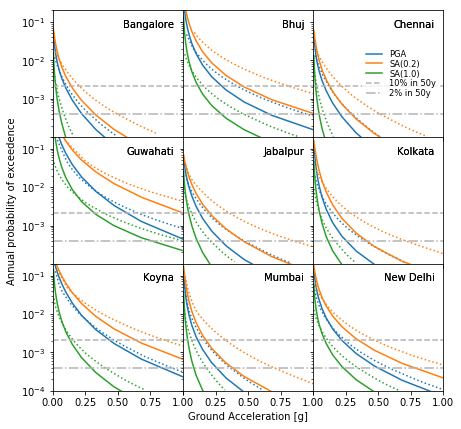

In [31]:
fig, axes = plt.subplots(PLOT_CITIES.shape[0], PLOT_CITIES.shape[1], 
                         figsize=(7, 7), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for curve_file in curve_files:
    poes, config = read_hazard_csv(curve_file)
    label = os.path.split(curve_file)[1]
    
    if config['investigation_time'] != T_INV:
        warnings.warn(
            'Investigation time %g instead of expected %g' %
            (config['investigation_time'], T_INV), UserWarning)
    
    if config['imt'] == 'PGV':
        warnings.warn('IMT %s units not properly reflected in axis label.' % 
                      config['imt'], UserWarning)
        
    for city_row, axes_row in zip(PLOT_CITIES, axes):
        for city, ax in zip(city_row, axes_row):
            city_series = df_table3[df_table3['City'] == city].squeeze()
            lon = round(round(5*city_series['Longitude (°E)'])/5, 1)
            lat = round(round(5*city_series['Latitude (°N)'])/5, 1)
            if (lon, lat, 0) in poes.index:
                poes_city = poes.loc[(lon, lat, 0)]

                trace = ax.semilogy(poes_city.index, poes_city.values, 
                                    label=config['imt'], alpha=alpha)

                digitized_csv = '%s_%s.csv' % (city.replace(' ','_'), config['imt'].replace('.0', ''))
                digitized_full = os.path.join(DIGITIZED_PATH, digitized_csv)
                if os.path.isfile(digitized_full):
                    data = np.genfromtxt(digitized_full, delimiter=',')
                    ax.plot(data[:, 0], data[:, 1], 
                            linestyle=':', alpha=alpha, color=trace[0].get_color())
                else:
                    print('%s not found ...' % digitized_csv)
            else:
                print('No site found near %s at %g°N, %g°E' % (city, lat, lon))

# add reference curves and set limits
for ax, city in zip(axes.ravel(), PLOT_CITIES.ravel()):
    ax.set_xlim((0, 1))
    ax.set_ylim((1e-4, 0.2))
    for prob, label, linestyle in zip(poes_plot, poe_labels, ['--', '-.', ':']):
        ax.axhline(prob, label=label, color='0.7', linestyle=linestyle)
        fig.sca(ax)
        annotate(city, loc='upper right')
    
axes[1,0].set_ylabel('Annual probability of exceedence')
[ax.yaxis.get_major_ticks()[1].label.set_visible(False) for ax in axes[:-1,0]]
axes[-1,1].set_xlabel('Ground Acceleration [g]')
[ax.xaxis.get_major_ticks()[0].label.set_visible(False) for ax in axes[-1,1:]]
leg = axes[0,-1].legend(loc='center right', frameon=True, fontsize='small', labelspacing=0.1)
leg.get_frame().set_linewidth(0.0)

fig.savefig(FIGURE_FILE, dpi=600, bbox_inches='tight')
anonymize(FIGURE_FILE)

In [32]:
map_files = sorted([
    os.path.abspath(item) for item in glob(os.path.join('map_collapsed_v1', '*360*.csv'))
    if all(key in item for key in ['hazard_map-', 'mean'])])
anonymize(map_files)

['~/src/indian-subcontinent-psha/Results/map_collapsed_v1/hazard_map-mean_360.csv']

In [34]:
map_file = map_files[0]
df_pga = pd.read_csv(map_file, header=1)
df_pga = df_pga[['lon', 'lat', 'PGA-0.002105']]

df_cities = df_table3.copy()
df_cities.rename(
    columns={'Longitude (°E)': 'lon', 'Latitude (°N)': 'lat'},
    inplace=True)
df_cities['lon'] = ((5*df_cities['lon']).round()/5).round(1)
df_cities['lat'] = ((5*df_cities['lat']).round()/5).round(1)
df_cities = df_cities[['City', 'lon', 'lat', 'Present']]

df_compare = pd.merge(df_cities, df_pga, on=['lon', 'lat'])
df_compare.drop(columns=['lon', 'lat'], inplace=True)
df_compare.set_index('City', inplace=True)
df_compare.rename(columns={
    'Present': 'NT2012 [g]', 
    'PGA-0.002105': 'A2018 [g]'}, inplace=True)
df_compare['Error [g]'] = (df_compare['A2018 [g]'] - 
                           df_compare['NT2012 [g]']).round(2)
df_compare['Error [%]'] = (100*(df_compare['A2018 [g]']/
                                df_compare['NT2012 [g]'] - 1)).round()
df_compare['A2018 [g]'] = df_compare['A2018 [g]'].round(3)
display(df_compare)

df_compare.columns = pd.MultiIndex.from_tuples(
    [tuple(item.split()) for item in df_compare.columns])
table_file = 'Table_3_Reproduced'
with codecs.open('%s.tex' % table_file, 'w', 'utf-8') as file_object:
    df_compare.to_latex(file_object, index=False)
out_file = shutil.copyfile('%s.tex' % table_file, 
                os.path.splitext(map_file)[0] + '.tex')


,NT2012 [g],A2018 [g],Error [g],Error [%]
City,,,,
Ahmedabad,0.11,0.066,-0.04,-40.0
Bangalore,0.11,0.093,-0.02,-15.0
Bhuj,0.42,0.295,-0.12,-30.0
Chennai,0.12,0.084,-0.04,-30.0
Dehradun,0.47,0.540,0.07,15.0
Guwahati,0.66,0.561,-0.10,-15.0
Hyderabad,0.09,0.071,-0.02,-21.0
Imphal,0.68,0.594,-0.09,-13.0
Jabalpur,0.19,0.126,-0.06,-34.0


In [41]:
gmls = logspace(.004, 10, 12)

In [42]:
imts = ['SA(0.1)', 'SA(0.15)', 'SA(0.2)', 'SA(0.3)', 'SA(0.5)', 'SA(0.7)', 
        'SA(1.0)', 'SA(1.5)', 'SA(2.0)', 'SA(2.5)', 'PGA']

In [43]:
for imt in imts:
    print('    "%s": [%s]' % (imt, ', '.join('%g' % gml for gml in gmls)))

    "SA(0.1)": [0.0047, 0.0056, 0.0068, 0.0082, 0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.033, 0.039, 0.047, 0.056, 0.068, 0.082, 0.1, 0.12, 0.15, 0.18, 0.22, 0.27, 0.33, 0.39, 0.47, 0.56, 0.68, 0.82, 1, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2, 10]
    "SA(0.15)": [0.0047, 0.0056, 0.0068, 0.0082, 0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.033, 0.039, 0.047, 0.056, 0.068, 0.082, 0.1, 0.12, 0.15, 0.18, 0.22, 0.27, 0.33, 0.39, 0.47, 0.56, 0.68, 0.82, 1, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2, 10]
    "SA(0.2)": [0.0047, 0.0056, 0.0068, 0.0082, 0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.033, 0.039, 0.047, 0.056, 0.068, 0.082, 0.1, 0.12, 0.15, 0.18, 0.22, 0.27, 0.33, 0.39, 0.47, 0.56, 0.68, 0.82, 1, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2, 10]
    "SA(0.3)": [0.0047, 0.0056, 0.0068, 0.0082, 0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.033, 0.039, 0.047, 0.056, 0.068, 0.082, 0.1, 0.12, 0.15, 0.18, 0.22, 0.27, 0.33, 0.39, 0.47, 0.56, 0.68, 0.82, 1, 1.